In [83]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import random
import pickle
from collections import Counter

import pandas as pd
import numpy as np

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# default plot stying changes
import seaborn as sns
sns.set_style("white")
sns.set_context("poster", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.set_palette("Set2")
colors = sns.color_palette('Set2',12)

import warnings
warnings.filterwarnings('ignore')

# Load Pickled Labels

In [2]:
directory = 'generated_data'
if not os.path.exists(directory):
    os.makedirs(directory)

train_labels = np.load('{0}/train_labels.dat'.format(directory))
test_labels = np.load('{0}/test_labels.dat'.format(directory))
print('Training labels shape: {0}'.format(train_labels.shape))
print('Testing labels shape:  {0}'.format(test_labels.shape))

Training labels shape: (7326,)
Testing labels shape:  (2603,)


# Load Custom Conversion Data

In [3]:
train_CustGray_2d = np.load('{0}/train_CustGray_2d.dat'.format(directory))
test_CustGray_2d = np.load('{0}/test_CustGray_2d.dat'.format(directory))
print('Custom Conversion training shape: {0}'.format(train_CustGray_2d.shape))
print('Custom Conversion testing shape:  {0}'.format(test_CustGray_2d.shape))

Custom Conversion training shape: (7326, 640)
Custom Conversion testing shape:  (2603, 640)


# Load Otsu's Binarization Threshold Data

In [4]:
train_OBT_2d = np.load('{0}/train_OBT_2d.dat'.format(directory))
test_OBT_2d = np.load('{0}/test_OBT_2d.dat'.format(directory))
print('Otsu training shape: {0}'.format(train_OBT_2d.shape))
print('Otsu testing shape:  {0}'.format(test_OBT_2d.shape))

Otsu training shape: (7326, 640)
Otsu testing shape:  (2603, 640)


# Load Adaptive Mean Threshold Data

In [5]:
train_AMT_2d = np.load('{0}/train_AMT_2d.dat'.format(directory))
test_AMT_2d = np.load('{0}/test_AMT_2d.dat'.format(directory))
print('Adaptive mean training shape: {0}'.format(train_AMT_2d.shape))
print('Adaptive mean testing shape:  {0}'.format(test_AMT_2d.shape))

Adaptive mean training shape: (7326, 640)
Adaptive mean testing shape:  (2603, 640)


# Load Adaptive Gaussian Threshold Data

In [6]:
train_AGT_2d = np.load('{0}/train_AGT_2d.dat'.format(directory))
test_AGT_2d = np.load('{0}/test_AGT_2d.dat'.format(directory))
print('Adaptive Gaussian training shape: {0}'.format(train_AGT_2d.shape))
print('Adaptive Gaussian testing shape:  {0}'.format(test_AGT_2d.shape))

Adaptive Gaussian training shape: (7326, 640)
Adaptive Gaussian testing shape:  (2603, 640)


# Load Principle Component Analysis Data

In [7]:
train_PCA_2d = np.load('{0}/train_PCA_2d.dat'.format(directory))
test_PCA_2d = np.load('{0}/test_PCA_2d.dat'.format(directory))
print('PCA training shape: {0}'.format(train_PCA_2d.shape))
print('PCA testing shape:  {0}'.format(test_PCA_2d.shape))

PCA training shape: (7326, 40)
PCA testing shape:  (2603, 40)


# Lists of Datasets

In [8]:
names = ['Cust', 'OBT', 'AMT', 'AGT', 'PCA']
l_train = [train_CustGray_2d, train_OBT_2d, train_AMT_2d, train_AGT_2d, train_PCA_2d]
l_test = [test_CustGray_2d, test_OBT_2d, test_AMT_2d, test_AGT_2d, test_PCA_2d]
overall_dict = {}

# Visualize Important Pixels

In [9]:
img_dir = 'imgs'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
    
def important_pixels(mdl, save_img, ht=32, wd=20):
    '''
    source: http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances_faces. \
                            html#example-ensemble-plot-forest-importances-faces-py
    '''
    importances = mdl.feature_importances_
    try:
        importances = importances.reshape(ht,wd)

        # Plot pixel importances
        plt.matshow(importances, cmap=plt.cm.hot)
        plt.axis('off')
        plt.savefig('{0}/{1}'.format(img_dir, save_img), bbox_inches='tight')
    except:
        pass

# Model Folder

In [39]:
mdl_dir = 'models'
if not os.path.exists(mdl_dir):
    os.makedirs(mdl_dir)

# Ada Boost Classifier

In [40]:
from sklearn.ensemble import AdaBoostClassifier

# Attributes
# estimators_ : list of classifiers
# classes_ : array of shape = [n_classes]
# n_classes_ : int
# estimator_weights_ : array of floats
# estimator_errors_ : array of floats
# feature_importances_ : array of shape = [n_features]

ab_dict = {}

for i,dataset in enumerate(l_train):
    n_estimators=50
    
    ab_clf = AdaBoostClassifier(base_estimator=None, n_estimators=n_estimators, learning_rate=1.0, 
                                 algorithm='SAMME.R', random_state=None)
    # cross-validation training score
    scores = cross_val_score(ab_clf, dataset, train_labels)
    
    # append results to dictionary
    ab_dict[('ada_boost_{0}'.format(names[i]),n_estimators)] = scores.mean()*100
    
    # models - save to disk for later use without re-running
    ab_mdl = ab_clf.fit(dataset, train_labels) 
    
    with open('{0}/ada_boost_{1}.pkl'.format(mdl_dir, names[i]), 'wb') as f:
        pickle.dump(ab_mdl, f)  
    
    # un-comment to get pixel importance images
    # important_pixels(ab_mdl, 'ada_boost_{0}'.format(names[i]))

In [41]:
overall_dict['ada_boost'] = ab_dict
ab_dict

{('ada_boost_AGT', 50): 19.601571674291097,
 ('ada_boost_AMT', 50): 19.901917264897509,
 ('ada_boost_Cust', 50): 20.760998576551458,
 ('ada_boost_OBT', 50): 20.48886398197746,
 ('ada_boost_PCA', 50): 28.022917438729621}

# Bagging Classifier

In [42]:
from sklearn.ensemble import BaggingClassifier

# Attributes
# base_estimator_ : list of estimators
# estimators_ : list of estimators
# estimators_samples_ : list of arrays
# estimators_features_ : list of arrays
# classes_ : array of shape = [n_classes]
# n_classes_ : int or list
# oob_score_ : float
# oob_decision_function_ : array of shape = [n_samples, n_classes]

bag_dict = {}

for i,dataset in enumerate(l_train):
    bag_clf = BaggingClassifier(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, 
                                bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, 
                                n_jobs=-1, random_state=None, verbose=0)
    # cross-validation training score
    scores = cross_val_score(bag_clf, dataset, train_labels)
    
    # append results to dictionary
    bag_dict['bagging_{0}'.format(names[i])] = scores.mean()*100
    
    # models - save to disk for later use without re-running
    bag_mdl = bag_clf.fit(dataset, train_labels) 
    
    with open('{0}/bagging_{1}.pkl'.format(mdl_dir, names[i]), 'wb') as f:
        pickle.dump(bag_mdl, f)  

In [43]:
overall_dict['bagging'] = bag_dict
bag_dict

{'bagging_AGT': 51.337489766195624,
 'bagging_AMT': 57.490501084915699,
 'bagging_Cust': 45.236659988408839,
 'bagging_OBT': 60.100031962135027,
 'bagging_PCA': 46.915530824940063}

# Gradient Boosting Classifier - TAKES A LONG TIME TO RUN

In [55]:
from sklearn.ensemble import GradientBoostingClassifier

# Attributes
# feature_importances_ : array, shape = [n_features]
# oob_improvement_ : array, shape = [n_estimators]
# train_score_ : array, shape = [n_estimators]
# loss_ : LossFunction
# init : BaseEstimator
# estimators_ : ndarray of DecisionTreeRegressor, shape = [n_estimators, loss_.K]
    
gb_dict = {}

for i,dataset in enumerate(l_train):
    n_estimators=100
    gb_clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=n_estimators, subsample=1.0, 
                                     min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                     max_depth=3, init=None, random_state=None, max_features=None, verbose=0, 
                                     max_leaf_nodes=None, warm_start=False, presort='auto')
    # cross-validation training score
    scores = cross_val_score(gb_clf, dataset, train_labels)
    
    # append results to dictionary
    gb_dict[('gradient_boost_{0}'.format(names[i]),n_estimators)] = scores.mean()*100
    
    # models - save to disk for later use without re-running
    gb_mdl = gb_clf.fit(dataset, train_labels)
    
    with open('{0}/gradient_boost_{1}.pkl'.format(mdl_dir, names[i]), 'wb') as f:
        pickle.dump(gb_mdl, f)  
    
    # un-comment to get pixel importance images
    # important_pixels(gb_mdl, 'gradient_boost_{0}'.format(names[i]))

In [56]:
overall_dict['gradient_boost'] = gb_dict
gb_dict

{('gradient_boost_AGT', 100): 66.214155600971665,
 ('gradient_boost_AMT', 100): 69.832856602220886,
 ('gradient_boost_Cust', 100): 48.772484782940104,
 ('gradient_boost_OBT', 100): 65.874941537370447,
 ('gradient_boost_PCA', 100): 51.773828521816633}

# Decision Tree Classifier

In [44]:
from sklearn.tree import DecisionTreeClassifier

# classes_ : array of shape = [n_classes] or a list of such arrays
# feature_importances_ : array of shape = [n_features]
# max_features_ : int,
# n_classes_ : int or list
# n_features_ : int
# n_outputs_ : int
# tree_ : Tree object

dtr_dict = {}

for i,dataset in enumerate(l_train):
    dtr_clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, 
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, 
                            max_leaf_nodes=None, class_weight=None, presort=False)

    # cross-validation training score
    scores = cross_val_score(dtr_clf, dataset, train_labels)
    
    # append results to dictionary
    dtr_dict['decision_tree_{0}'.format(names[i])] = scores.mean()*100
    
    # models - save to disk for later use without re-running
    dtr_mdl = dtr_clf.fit(dataset, train_labels)
    
    with open('{0}/decision_tree_{1}.pkl'.format(mdl_dir, names[i]), 'wb') as f:
        pickle.dump(dtr_mdl, f)  
    
    # un-comment to get pixel importance images
    # important_pixels(dtr_mdl, 'decision_tree{0}'.format(names[i]))

In [45]:
overall_dict['decision_tree'] = dtr_dict
dtr_dict

{'decision_tree_AGT': 36.377229241488344,
 'decision_tree_AMT': 40.580427748473205,
 'decision_tree_Cust': 32.637444375005117,
 'decision_tree_OBT': 45.659452625184919,
 'decision_tree_PCA': 33.360936134116564}

# Extra Trees Classifier

In [46]:
from sklearn.ensemble import ExtraTreesClassifier

etr_dict = {}

for i,dataset in enumerate(l_train):
    
    etr_clf = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, 
                    min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, 
                    bootstrap=False, oob_score=False, n_jobs=-1, random_state=None, verbose=0, warm_start=False, 
                    class_weight=None)

    # cross-validation training score
    scores = cross_val_score(etr_clf, dataset, train_labels)
    
    # append results to dictionary
    etr_dict['extra_trees_{0}'.format(names[i])] = scores.mean()*100
    
    # models - save to disk for later use without re-running
    etr_mdl = etr_clf.fit(dataset, train_labels)
    
    with open('{0}/extra_trees_{1}.pkl'.format(mdl_dir, names[i]), 'wb') as f:
        pickle.dump(etr_mdl, f)  
    
    # un-comment to get pixel importance images
    # important_pixels(etr_mdl, 'extra_tree{0}'.format(names[i]))

In [47]:
overall_dict['extra_trees'] = etr_dict
etr_dict

{'extra_trees_AGT': 51.801369261299577,
 'extra_trees_AMT': 57.643004897438551,
 'extra_trees_Cust': 44.390668877489368,
 'extra_trees_OBT': 60.047451011309469,
 'extra_trees_PCA': 39.775958600234702}

In [48]:
etr_clf = ExtraTreesClassifier()
etr_mdl = etr_clf.fit(train_OBT_2d, train_labels)
print(classification_report(test_labels, etr_clf.predict(test_OBT_2d), digits=2))

             precision    recall  f1-score   support

          0       0.43      0.59      0.50       180
          1       0.64      0.82      0.72       509
          2       0.63      0.63      0.63       394
          3       0.56      0.47      0.51       295
          4       0.61      0.73      0.66       256
          5       0.59      0.51      0.54       231
          6       0.56      0.46      0.51       199
          7       0.68      0.50      0.58       202
          8       0.47      0.30      0.37       175
          9       0.53      0.41      0.47       162

avg / total       0.59      0.59      0.58      2603



# Random Forrest Classifier

In [49]:
from sklearn.ensemble import RandomForestClassifier

# Attributes
# estimators_ : list of DecisionTreeClassifier
# classes_ : array of shape = [n_classes] or a list of such arrays
# n_classes_ : int or list
# n_features_ : int
# n_outputs_ : int
# feature_importances_ : array of shape = [n_features]
# oob_score_ : float
# oob_decision_function_ : array of shape = [n_samples, n_classes]
    
rf_dict = {}

for i,dataset in enumerate(l_train):
    rf_clf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                                max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=-1, random_state=None, 
                                verbose=0, warm_start=False, class_weight=None)

    # cross-validation training score
    scores = cross_val_score(rf_clf, dataset, train_labels)
    
    # append results to dictionary
    rf_dict['random_forrest_{0}'.format(names[i])] = scores.mean()*100
    
    # models - save to disk for later use without re-running
    rf_mdl = rf_clf.fit(dataset, train_labels)
    
    with open('{0}/random_forrest_{1}.pkl'.format(mdl_dir, names[i]), 'wb') as f:
        pickle.dump(rf_mdl, f)  
    
    # un-comment to get pixel importance images
    # important_pixels(rf_mdl, 'random_forrest{0}'.format(names[i]))

In [50]:
overall_dict['random_forrest'] = rf_dict
rf_dict

{'random_forrest_AGT': 47.556399994786801,
 'random_forrest_AMT': 53.480055026377549,
 'random_forrest_Cust': 42.971244069585133,
 'random_forrest_OBT': 57.821828551930906,
 'random_forrest_PCA': 41.70029597266894}

# KNN

In [51]:
from sklearn.neighbors import KNeighborsClassifier
    
knn_dict = {}

for i,dataset in enumerate(l_train):
    knn_clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                   metric='minkowski', metric_params=None, n_jobs=-1)

    # cross-validation training score
    scores = cross_val_score(knn_clf, dataset, train_labels)
    
    # append results to dictionary
    knn_dict['kneighbors_{0}'.format(names[i])] = scores.mean()*100
    
    # models - save to disk for later use without re-running
    knn_mdl = knn_clf.fit(dataset, train_labels)
    
    with open('{0}/kneighbors_{1}.pkl'.format(mdl_dir, names[i]), 'wb') as f:
        pickle.dump(knn_mdl, f)  

In [52]:
overall_dict['kneighbors'] = knn_dict
knn_dict

{'kneighbors_AGT': 60.278115454419712,
 'kneighbors_AMT': 63.771514237182359,
 'kneighbors_Cust': 44.868008839839568,
 'kneighbors_OBT': 56.469231326074706,
 'kneighbors_PCA': 61.575175530410156}

# SVM Classifier

In [53]:
from sklearn.svm import SVC

svc_dict = {}

for i,dataset in enumerate(l_train):
    svc_clf = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False, 
                  tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, 
                  decision_function_shape=None)

    # cross-validation training score
    scores = cross_val_score(svc_clf, dataset, train_labels)
    
    # append results to dictionary
    svc_dict['svc_{0}'.format(names[i])] = scores.mean()*100
    
    # models - save to disk for later use without re-running
    svc_mdl = svc_clf.fit(dataset, train_labels)
    
    with open('{0}/svc_{1}.pkl'.format(mdl_dir, names[i]), 'wb') as f:
        pickle.dump(svc_mdl, f)  

In [54]:
overall_dict['svc'] = svc_dict
svc_dict

{'svc_AGT': 19.178291874734157,
 'svc_AMT': 19.178291874734157,
 'svc_Cust': 19.178291874734157,
 'svc_OBT': 19.178291874734157,
 'svc_PCA': 65.969377416059118}

# Logistic Regression Classifier

In [57]:
from sklearn.linear_model import SGDClassifier

logr_dict = {}

for i,dataset in enumerate(l_train):
    logr_clf = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, n_iter=5, 
                             shuffle=True, verbose=0, epsilon=0.1, n_jobs=-1, random_state=None, learning_rate='optimal', 
                             eta0=0.0, power_t=0.5, class_weight=None, warm_start=False, average=False)

    # cross-validation training score
    scores = cross_val_score(logr_clf, dataset, train_labels)
    
    # append results to dictionary
    logr_dict['log_regression_{0}'.format(names[i])] = scores.mean()*100
    
    # models - save to disk for later use without re-running
    logr_mdl = logr_clf.fit(dataset, train_labels)
    
    with open('{0}/log_regression_{1}.pkl'.format(mdl_dir, names[i]), 'wb') as f:
        pickle.dump(logr_mdl, f)  

In [58]:
overall_dict['log_regression'] = logr_dict
logr_dict

{'log_regression_AGT': 16.256614649687407,
 'log_regression_AMT': 15.024943088028555,
 'log_regression_Cust': 11.165977548156027,
 'log_regression_OBT': 12.922081680323801,
 'log_regression_PCA': 16.626610884751315}

In [59]:
list(overall_dict.values())

[{'svc_AGT': 19.178291874734157,
  'svc_AMT': 19.178291874734157,
  'svc_Cust': 19.178291874734157,
  'svc_OBT': 19.178291874734157,
  'svc_PCA': 65.969377416059118},
 {'bagging_AGT': 51.337489766195624,
  'bagging_AMT': 57.490501084915699,
  'bagging_Cust': 45.236659988408839,
  'bagging_OBT': 60.100031962135027,
  'bagging_PCA': 46.915530824940063},
 {('ada_boost_AGT', 50): 19.601571674291097,
  ('ada_boost_AMT', 50): 19.901917264897509,
  ('ada_boost_Cust', 50): 20.760998576551458,
  ('ada_boost_OBT', 50): 20.48886398197746,
  ('ada_boost_PCA', 50): 28.022917438729621},
 {'random_forrest_AGT': 47.556399994786801,
  'random_forrest_AMT': 53.480055026377549,
  'random_forrest_Cust': 42.971244069585133,
  'random_forrest_OBT': 57.821828551930906,
  'random_forrest_PCA': 41.70029597266894},
 {('gradient_boost_AGT', 100): 66.214155600971665,
  ('gradient_boost_AMT', 100): 69.832856602220886,
  ('gradient_boost_Cust', 100): 48.772484782940104,
  ('gradient_boost_OBT', 100): 65.87494153737

In [197]:
# get model names
mdls = [k for k,v in overall_dict.items()]

# get cross fold scores for each model
lst_cnts = [[v for k,v in overall_dict[mdl].items()] for mdl in mdls]

# extended names for readability
names_ext = ['Custom', 'Otsu', 'Adapt. Mean', 'Adapt. Gaussian', 'PCA']

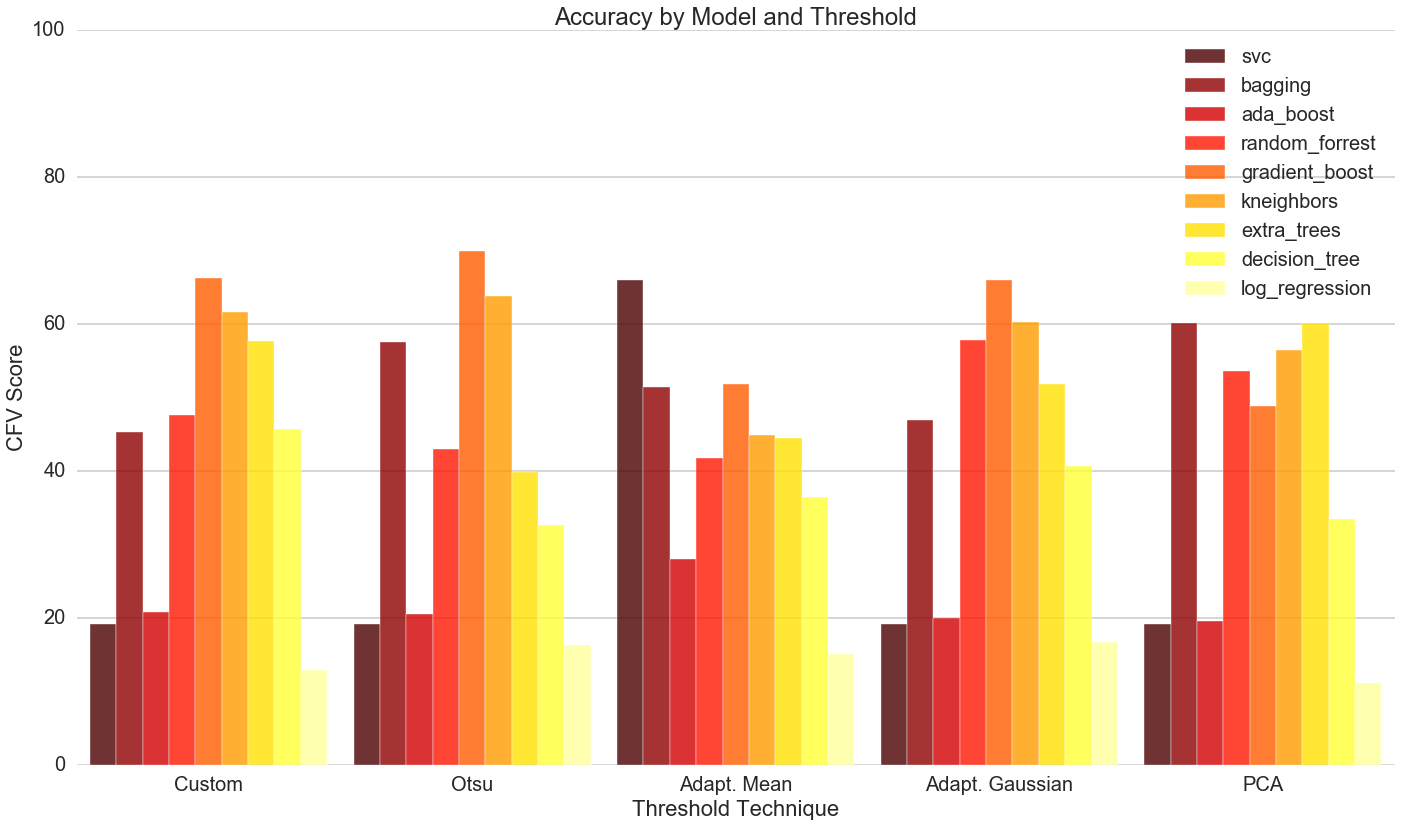

In [196]:
# colors
sns.set_palette("hot")
colors = sns.color_palette('hot',9)

# make figure
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)

# spacing/size
width = 0.1
steps = [-0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4]
pos = []
for j in steps:
    temp = []
    for k in range(1,6):
        temp.append(k+j)
    pos.append(temp)
pos

# plots
for i in range(9):
    plt.bar(pos[i], lst_cnts[i], width=width, align='center', color=colors[i], alpha=0.8, edgecolor='w', 
            label=mdls[i])

# labels/titles
plt.legend(loc="best")
plt.xlabel('Threshold Technique')
plt.ylabel('CFV Score')
plt.title('Accuracy by Model and Threshold')

ticks = range(1,6)
plt.xlim(0.5,5.5)
plt.xticks(ticks, names_ext)
plt.ylim(0,100)

# remove border
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.spines["left"].set_visible(False)

# show grid
ax.yaxis.grid(True) 

# plot that biddy
plt.tight_layout()
_ = plt.show()

In [211]:
df = pd.DataFrame(overall_dict)
df

,ada_boost,bagging,decision_tree,extra_trees,gradient_boost,kneighbors,log_regression,random_forrest,svc
AGT,19.901917,46.915531,40.580428,51.801369,65.874942,60.278115,16.626611,57.821829,19.178292
AMT,28.022917,51.337490,36.377229,44.390669,51.773829,44.868009,15.024943,41.700296,65.969377
Cust,20.760999,45.236660,45.659453,57.643005,66.214156,61.575176,12.922082,47.556400,19.178292
OBT,20.488864,57.490501,32.637444,39.775959,69.832857,63.771514,16.256615,42.971244,19.178292
PCA,19.601572,60.100032,33.360936,60.047451,48.772485,56.469231,11.165978,53.480055,19.178292


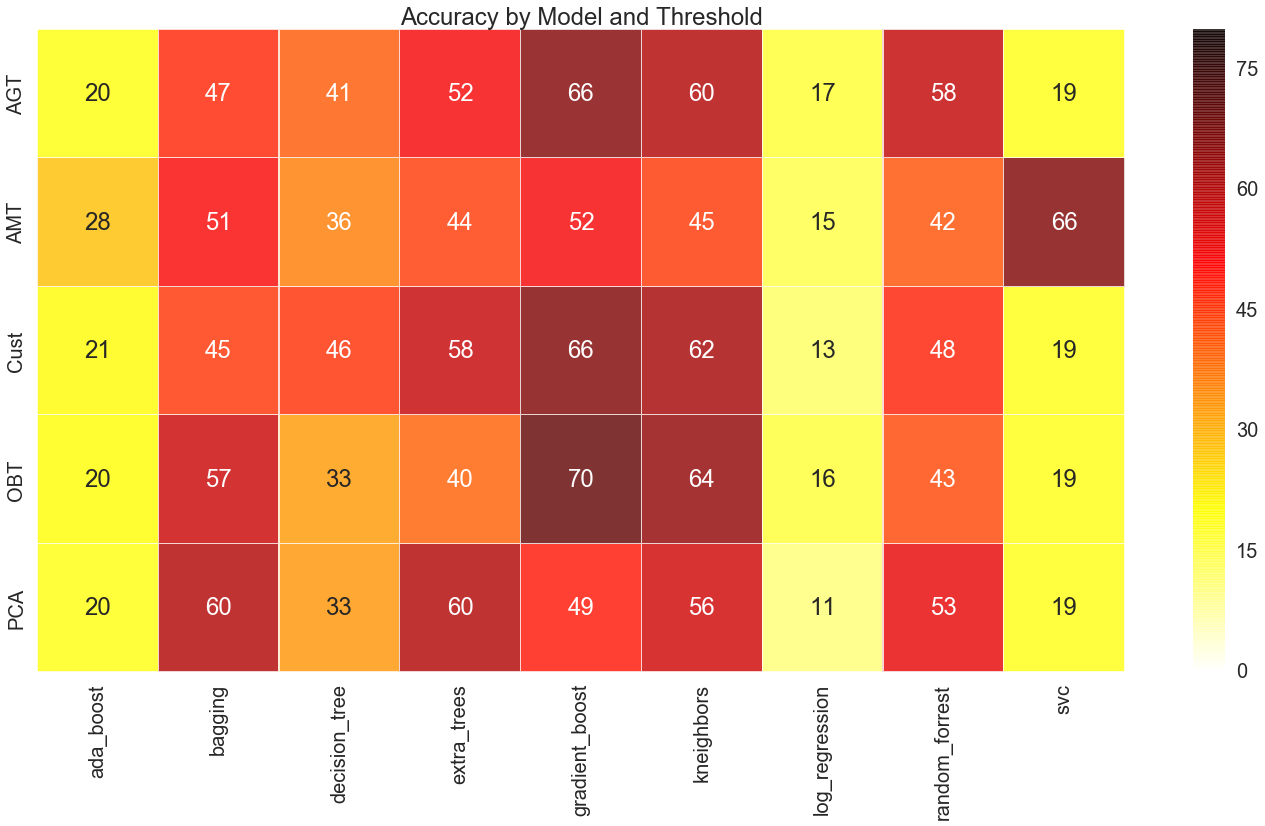

In [240]:
# colors
sns.set_palette("hot")
colors = sns.color_palette('hot',9)

# make figure
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)

# plots
ax = sns.heatmap(df, annot=True, cmap="hot_r", alpha=0.8, linewidths=.1, vmin=0, vmax=80)

# labels/titles
plt.title('Accuracy by Model and Threshold')

# remove border
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.spines["left"].set_visible(False)

# show grid
ax.yaxis.grid(False) 

# plot that biddy
plt.tight_layout()
_ = plt.show()